In [ ]:
import pandas as pd
import os
import glob
import email
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
import string
import re
import nltk
import datetime as dt
from PIL import Image
from string import digits
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/Capstone/Table/"

In [ ]:
df = pd.read_csv(data_path+"complete_data.csv")

In [ ]:
df.head()

,message_id,date,from,to,subject,cc,bcc,body
0,allen-p\all_documents\1,"Wed, 13 Dec 2000 18:41:00 -0800 (PST)",['1.11913372.-2@multexinvestornetwork.com'],['pallen@enron.com'],"December 14, 2000 - Bear Stearns' predictions ...",NaN,NaN,In today's Daily Update you'll find free repor...
1,allen-p\all_documents\10,"Wed, 13 Dec 2000 08:35:00 -0800 (PST)",['messenger@ecm.bloomberg.com'],NaN,Bloomberg Power Lines Report,NaN,NaN,Here is today's copy of Bloomberg Power Lines....
2,allen-p\all_documents\100,"Mon, 9 Oct 2000 07:16:00 -0700 (PDT)",['phillip.allen@enron.com'],['keith.holst@enron.com'],Consolidated positions: Issues & To Do list,NaN,NaN,---------------------- Forwarded by Phillip K ...
3,allen-p\all_documents\101,"Mon, 9 Oct 2000 07:00:00 -0700 (PDT)",['phillip.allen@enron.com'],['keith.holst@enron.com'],Consolidated positions: Issues & To Do list,NaN,NaN,---------------------- Forwarded by Phillip K ...
4,allen-p\all_documents\102,"Thu, 5 Oct 2000 06:26:00 -0700 (PDT)",['phillip.allen@enron.com'],['david.delainey@enron.com'],NaN,NaN,NaN,"Dave, \n\n Here are the names of the west desk..."


In [ ]:
df = df.drop_duplicates(df.columns.difference(['message_id'])).reset_index()
df.drop(["index"], axis= 1, inplace = True)

## HTML parsing

In [ ]:
def parse_html(text):
  pattern = "<html>(.+?)</html>"
  if re.search(pattern, text, re.IGNORECASE + re.DOTALL):
    soup = BeautifulSoup(text, 'html5')
    for data in soup(['style']):
          data.decompose()
    soup = BeautifulSoup(soup.get_text(), 'html5')
    return soup.get_text()
  else:
    return text

In [ ]:
df['body_html'] = df['body'].map(parse_html)

## Threads parsing

In [ ]:
# Suppose no lower case To From Subject
def chain_split(a, subject):
  # print(a)
  text = a
  a = a.split('\n')
  end = []
  start = []
  subs = []
  i = 0
  if_chain = False
  while i < len(a):
    if re.search(re.compile(r'forwarded by|original message|--original', re.IGNORECASE),a[i]):
      start.append(i)
    elif len(start)==len(end) and re.search(r'From:',a[i]):
      start.append(i)
    elif len(start)==len(end) and re.search(r'To:',a[i]):
      start.append(i-3)
    elif re.search(r'Subject:',a[i]):
      s = i
      # while i < len(a) and a[i]:
      #   i += 1
      # i -= 1
      if len(end)==len(start):
        if len(start)!=0:
          subs[-1] = s
          end[-1] = i
      else:
        subs.append(s)
        end.append(i)
    i+=1
  
  if len(start)>len(end):
      start = start[:len(end)]

  emails = []
  subjects = []
  pre = 0
  subjects.append(subject)
  for sub in subs: 
    subjects.append(a[sub].split('Subject:')[-1].strip('\t'))
  for s, e in zip(start, end):
    if pre != s:
      emails.append("\n".join(a[pre:s]).strip('\n'))
    else:
      emails.append(" ")
    pre = e+1
    for i in range(s, e+1):
      a[i] = ""
  if pre < len(a):
    emails.append("\n".join(a[pre:]).strip('\n'))
  else:
    emails.append(" ")
  
  combine = [(len(emails)-i, sub, email) for i, (sub, email) in enumerate(zip(subjects, emails))]
  combine.reverse()
  a = "\n".join(a)
  return len(start), combine

In [ ]:
df['new_body'] = df.apply(lambda x:chain_split(x['body_html'],x['subject']), axis=1)

In [ ]:
df['chain_len'] = df['new_body'].map(lambda x:x[0])
df['subjects_emails'] = df['new_body'].map(lambda x:x[1])

## Threads length analysis


In [ ]:
# 'forwarded by|original message|--original'
df['chain_len'].value_counts().sort_index(ascending=False)

97         1
88         1
86         1
84         1
82         1
       ...  
4       5078
3      11088
2      24177
1      63514
0     144837
Name: chain_len, Length: 72, dtype: int64

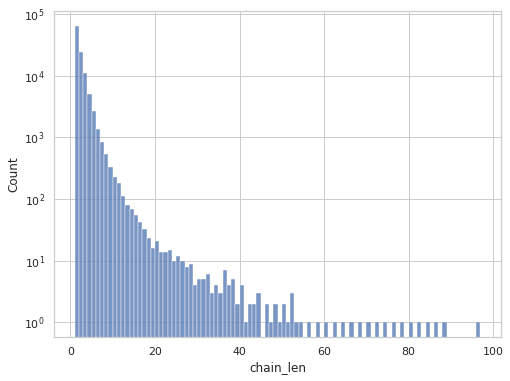

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(data=df[(df['chain_len']>0)]['chain_len'], bins="doane", binwidth = 1)
axes.set_yscale('log')

## Split email threads

In [ ]:
df_new = df[['message_id','subjects_emails']].explode('subjects_emails')

In [ ]:
df_new.reset_index(inplace = True)
df_new.drop(["index"], axis= 1, inplace = True)
df_new

,message_id,subjects_emails
0,allen-p\all_documents\1,"(1, December 14, 2000 - Bear Stearns' predicti..."
1,allen-p\all_documents\10,"(1, Bloomberg Power Lines Report, Here is toda..."
2,allen-p\all_documents\100,"(1, Consolidated positions: Issues & To Do li..."
3,allen-p\all_documents\100,"(2, Consolidated positions: Issues & To Do li..."
4,allen-p\all_documents\100,"(3, Consolidated positions: Issues & To Do lis..."
...,...,...
472965,zufferli-j\sent_items\98,"(1, Calgary Analyst/Associate, Analyst\t\t\t\t..."
472966,zufferli-j\sent_items\99,"(1, ali's essays, Hi John\n\n How was T..."
472967,zufferli-j\sent_items\99,"(2, RE: ali's essays, ..."
472968,zufferli-j\sent_items\99,"(3, RE: ali's essays, i don't know about the h..."


In [ ]:
# df_new = df_new[df_new['subjects_emails'].notna()]
df_new['idx'] = df_new['subjects_emails'].map(lambda x:x[0])
df_new['subject'] = df_new['subjects_emails'].map(lambda x:x[1])
df_new['email'] = df_new['subjects_emails'].map(lambda x:x[2])
# df_new = df_new[(df_new['email']!=' ') & (df_new['subject']!=' ')]

In [ ]:
df_new['email_id'] = df_new.apply(lambda x: x['message_id']+'#'+str(x['idx']), axis = 1)

In [ ]:
df_new = df_new[["email_id", "subject", "email"]]
df_new 

,email_id,subject,email
0,allen-p\all_documents\1#1,"December 14, 2000 - Bear Stearns' predictions ...",In today's Daily Update you'll find free repor...
1,allen-p\all_documents\10#1,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....
2,allen-p\all_documents\100#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...
3,allen-p\all_documents\100#2,Consolidated positions: Issues & To Do list,"Phillip,\n Below is the issues & to do list as..."
4,allen-p\all_documents\100#3,Consolidated positions: Issues & To Do list,
...,...,...,...
472965,zufferli-j\sent_items\98#1,Calgary Analyst/Associate,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...
472966,zufferli-j\sent_items\99#1,ali's essays,Hi John\n\n How was Thanksgiving? Was th...
472967,zufferli-j\sent_items\99#2,RE: ali's essays,01:41 PM\n\n\n\n\n\n\njust...
472968,zufferli-j\sent_items\99#3,RE: ali's essays,i don't know about the heart classes. i'll lo...


In [ ]:
df_new.to_csv(data_path+"split_threads.csv")

In [ ]:
df_new

,email_id,subject,email
0,allen-p\all_documents\1#1,"December 14, 2000 - Bear Stearns' predictions ...",In today's Daily Update you'll find free repor...
1,allen-p\all_documents\10#1,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....
2,allen-p\all_documents\100#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...
3,allen-p\all_documents\100#2,Consolidated positions: Issues & To Do list,"Phillip,\n Below is the issues & to do list as..."
4,allen-p\all_documents\100#3,Consolidated positions: Issues & To Do list,
...,...,...,...
472965,zufferli-j\sent_items\98#1,Calgary Analyst/Associate,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...
472966,zufferli-j\sent_items\99#1,ali's essays,Hi John\n\n How was Thanksgiving? Was th...
472967,zufferli-j\sent_items\99#2,RE: ali's essays,01:41 PM\n\n\n\n\n\n\njust...
472968,zufferli-j\sent_items\99#3,RE: ali's essays,i don't know about the heart classes. i'll lo...


In [ ]:
df_new.sample(n=300).to_csv(data_path+"split_threads_sample.csv")